# 월간 데이콘 법원 판결 예측 AI 경진대회
특정 사건에서 첫 번째 당사자와 두 번째 당사자 중 첫 번째 당사자의 승소 여부를 예측
https://dacon.io/competitions/official/236112/overview/description
- ID : 사건 샘플 ID
- first_party : 사건의 첫 번째 당사자
- second_party : 사건의 두 번째 당사자
- facts : 사건 내용
- first_party_winner : 첫 번째 당사자의 승소 여부 (0 : 패배, 1 : 승리)

+++ 비교해 확인
https://dacon.io/competitions/official/235671/codeshare/2006?page=1&dtype=recent

## 라이브러리 및 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import nltk # 문장 토크나이저
#nltk.download('punkt')

# 영어 불용어 - 불용어 모아 놓은 리스트 다운로드해 제거
nltk.download('all')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize # 토큰화
from nltk.stem.porter import PorterStemmer # 어근 동일화 <-> 이거 말고도 "Lancaster Stemmer"

# 표제어 추출
from nltk.stem import WordNetLemmatizer

# 정규표현 처리
import re

In [ ]:
# 구글 드라이브에서 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 영어 데이터 전처리 함수
stops = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

def cleaning(str):
    replaceAll = str

    # 특수문자 및 기호 등 필요없는 문자 제거
    only_english = re.sub('[^a-zA-Z]', ' ', replaceAll)

    # 대소문자 모두 소문자로 통일
    no_capitals = only_english.lower().split()

    # 불용어(분석에 필요없는 토큰) 제거
    no_stops = [word for word in no_capitals if not word in stops]

    # 어근 추츨을 통한 텍스트 정규화 작업
    stemmer_words = [stemmer.stem(word) for word in no_stops]
    return ' '.join(stemmer_words)

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/0000/dacon_lawwinner/train.csv")

### 토크나이저 (기본base)


● Sentence Tokenization
마침표나 느낌표, 물음표 등으로 구분
마침표의 경우 항상 문장의 마지막이 아니라 Mr. / Dr. 등등 문장 중간에도 들어갈 수 있음. 그러나 영어 문장의 경우 이러한 케이스도 잘 잡아주고 있는 것을 확인

- 좋은 vocab을 만드는 것이 곧 토크나이징 퀄리티와 직결
- 모델이 맥락 지식을 잘 학습하여 downstream task에서 좋은 성능을 내는 데에까지 영향
- 모델 학습에 들어가기에 앞서 vocab을 잘 살펴볼 필요

In [ ]:
train['facts_lst'] = 0 # 문장 토큰화
train['facts_word'] = 0 # 단어 토큰화

for i in range(2478):
  train.facts_lst[i] = nltk.sent_tokenize(train.facts[i])
  train.facts_word[i] = word_tokenize(train.facts[i])

In [ ]:
train.head(5)

,ID,first_party,second_party,facts,first_party_winner,facts_lst,facts_word
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"[On June 27, 1962, Phil St. Amant, a candidate...","[On, June, 27, ,, 1962, ,, Phil, St., Amant, ,..."
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,[Ramon Nelson was riding his bike when he suff...,"[Ramon, Nelson, was, riding, his, bike, when, ..."
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,[An Alabama state court convicted Billy Joe Ma...,"[An, Alabama, state, court, convicted, Billy, ..."
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,[Victor Linkletter was convicted in state cour...,"[Victor, Linkletter, was, convicted, in, state..."
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"[On April 24, 1953 in Selma, Alabama, an intru...","[On, April, 24, ,, 1953, in, Selma, ,, Alabama..."


## EDA

### Base

In [ ]:
train.isnull().sum()

ID                    0
first_party           0
second_party          0
facts                 0
first_party_winner    0
facts_lst             0
facts_word            0
dtype: int64

In [ ]:
# 동명이인 일까
# 아님 동일한 사람의 기록일까
len(train.first_party.unique()),len(train.second_party.unique())

(2110, 1974)

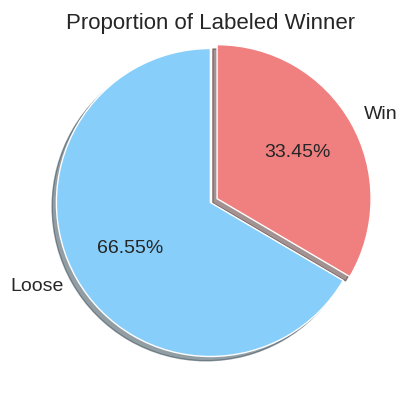

1    1649
0     829
Name: first_party_winner, dtype: int64


In [ ]:
# set the figure size
plt.figure(figsize=(9, 5))

# set the style
plt.style.use('seaborn-darkgrid')

# set the colors
colors = ['lightskyblue', 'lightcoral']

# generate a pie plot
plt.pie(train['first_party_winner'].value_counts(), explode=(0, 0.05), labels=["Loose", "Win"],
        autopct="%0.2f%%", textprops={'fontsize': 14}, shadow=True, startangle=90, colors=colors)

# add a title
plt.title('Proportion of Labeled Winner', size=16, y=0.93)

# show the plot
plt.show()

# 승소 값 확인
print(train['first_party_winner'].value_counts())

Text(0, 0.5, 'freq')

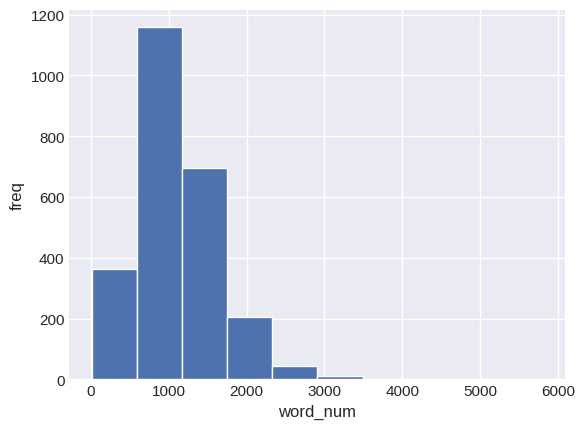

In [ ]:
#제목의 글자 수 히스토그램
# https://skyjwoo.tistory.com/entry/%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC-EDAExploratory-Data-Analysis
ax = train['facts'].str.len().hist()

ax.set_xlabel('word_num')
ax.set_ylabel('freq')

1000자 내외로 분포

Text(0, 0.5, 'freq')

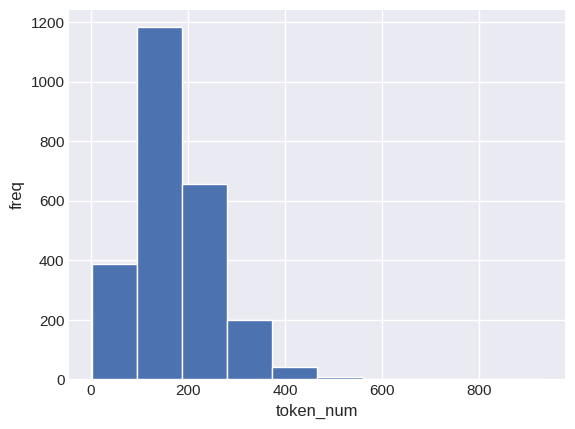

In [ ]:
#토큰 수
## 띄어쓰기, 탭, 개행 등의 구분자로 구분된 단위를 토큰
ax = train['facts'].str.split().map(lambda x: len(x)).hist()

ax.set_xlabel('token_num')
ax.set_ylabel('freq')

- 대부분 500개 이하의 토큰(어절)이 쓰였음 -  대부분의 구분자가 띄어쓰기라는 걸 고려
- 200자 내외로 분포

Text(0, 0.5, 'freq')

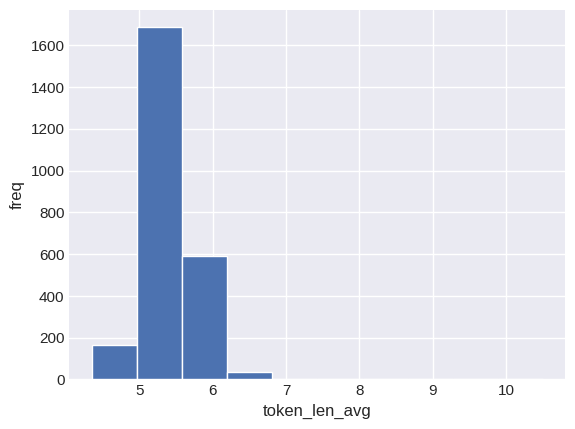

In [ ]:
#토큰별 길이 평균
ax = train['facts'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

ax.set_xlabel('token_len_avg')
ax.set_ylabel('freq')

<Axes: >

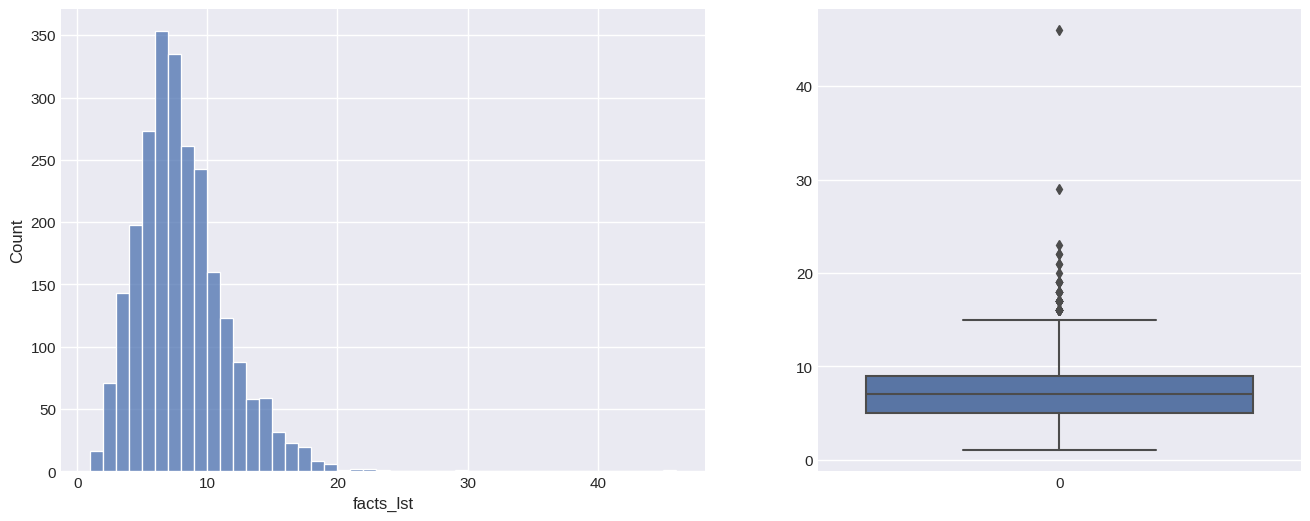

In [ ]:
# sentence
original_sent_counts = train['facts_lst'].apply(len)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(original_sent_counts, binwidth=1, ax=axs[0])
sns.boxplot(original_sent_counts, ax=axs[1])

<Axes: >

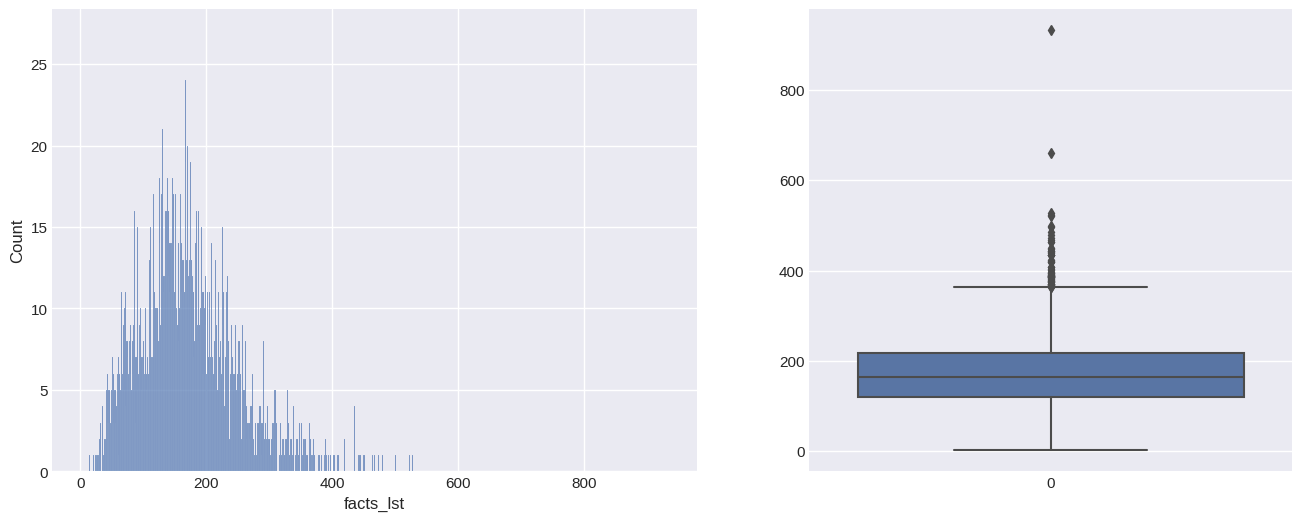

In [ ]:
# word 수
original_word_counts = train['facts_lst'].apply(lambda x:len(' '.join(x).split(' ')))

fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(original_word_counts, binwidth=1, ax=axs[0])
sns.boxplot(original_word_counts, ax=axs[1])

본문 길이 평균적으로 7문장 및 173개 정도 단어로 구성.

이는 기존 summary task에서 많이 쓰이는 CNN(평균 34문장, 760단어)이나 DailyMail(평균 29문장, 653단어) 같은 데이터와 비교했을 때 상당히 길이가 적은 편.

참고 : https://dacon.io/competitions/official/235671/codeshare/2006?page=1&dtype=recent

### 문장 및 단어 수 시각화

In [ ]:
# set the random state
random_state = 4041

# import the wordcloud library
from wordcloud import WordCloud

# concat all the text for each labels
win_facts = [''.join(t) for t in train[train['first_party_winner']==1]['facts']]
win_strings = ' '.join(map(str, win_facts))
loose_text = [''.join(t) for t in train[train['first_party_winner']==0]['facts']]
loose_strings = ' '.join(map(str, loose_text))

# generate word clouds
win_cloud = WordCloud(width=800, height=400, max_words=500, background_color='white', random_state=random_state).generate(win_strings)
loose_cloud = WordCloud(width=800, height=400, max_words=500, random_state=random_state).generate(loose_strings)

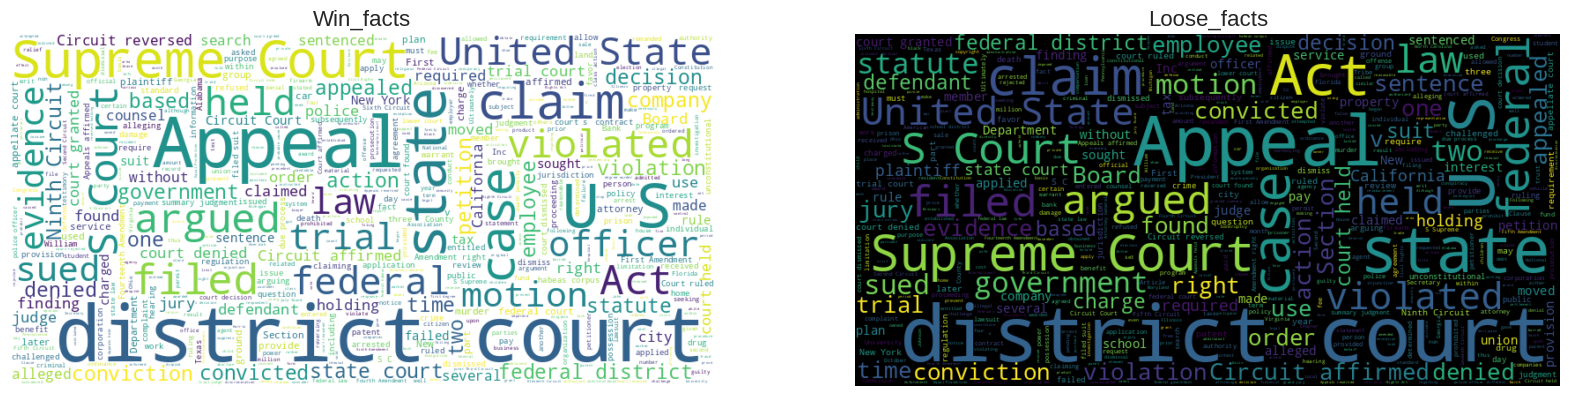

In [ ]:
# create subplots for the generated clouds
fig, axes = plt.subplots(1, 2, figsize = (20,20))
axes[0].imshow(win_cloud, interpolation='bilinear')
axes[1].imshow(loose_cloud, interpolation='bilinear')

# turn the axis off
[ax.axis('off') for ax in axes]

# add titles
axes[0].set_title('Win_facts', fontsize=16)
axes[1].set_title('Loose_facts', fontsize=16)

# show the figure
plt.show()

In [ ]:
# 제일 많이 등장하는 문장
win_word = list(train[train.first_party_winner == 1].facts_lst) # 첫번째 party win
loose_word = list(train[train.first_party_winner == 0].facts_lst) # 첫번째 party loose
ww_list = []
lw_list = []

for i in win_word:
  ww_list = ww_list + i

for i in loose_word:
  lw_list = lw_list + i


from nltk import Text # Text(토큰리스트, [name=이름])
ww_text = Text(ww_list, name="win")
lw_text = Text(lw_list, name="loose")

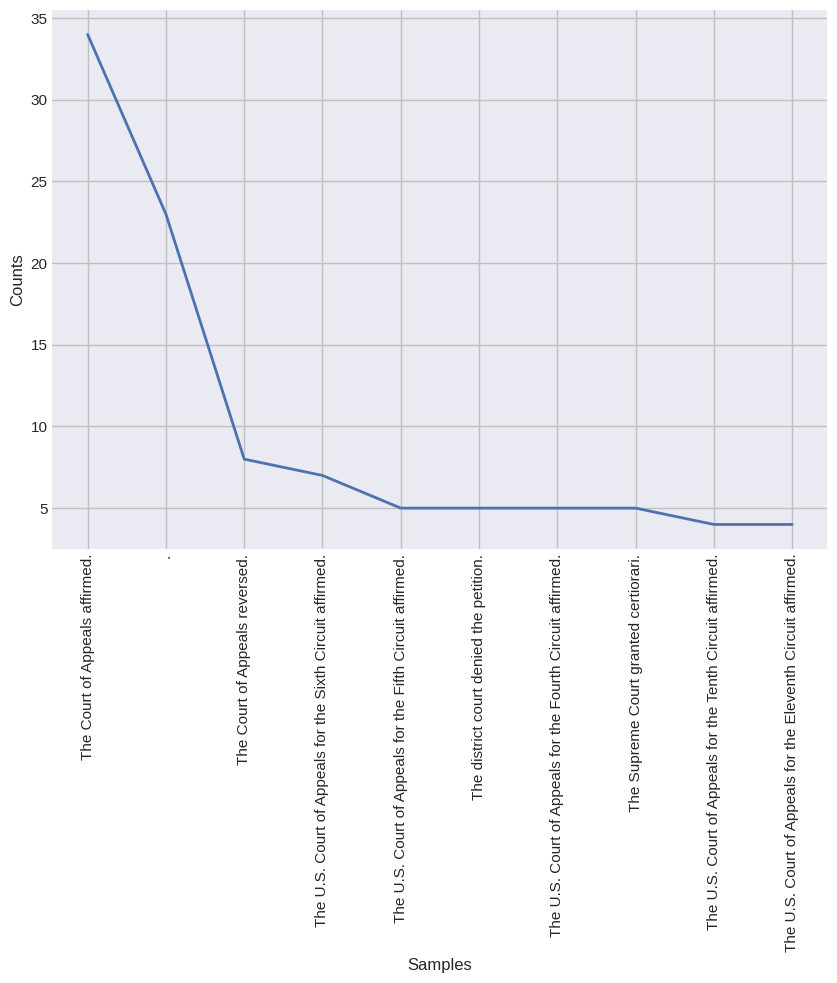

In [ ]:
plt.figure(figsize=(10,7))
ww_text.plot(10)
plt.show()

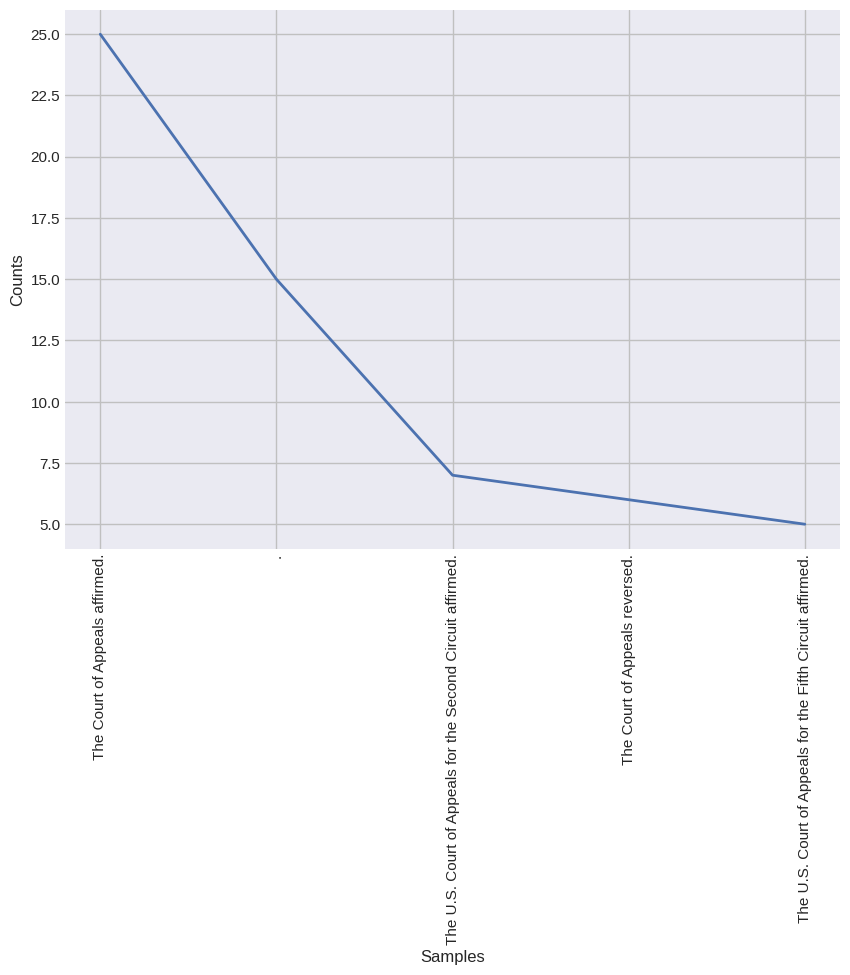

In [ ]:
plt.figure(figsize=(10,7))
lw_text.plot(5)
plt.show()

######### win

- The Court of Appeals affirmed
- .
- The Court of Appeals reversed
- The U.S. Court of Appeals for the Sixth Circuit affirmed.
- The U.S. Court of Appeals for the Fifth Circuit affirmed.
- The distinct court denied the petition
- The U.S. Court of Appeals for the Fourth Circuit affirmed.
- The Supreme Court granted certiorari.
- The U.S. Court of Appeals for the Tenth Circuit affirmed.
- The U.S. Court of Appeals for the Elevneth Circuit affirmed.


########## loose

- The Court of Appeals affirmed
- .
- The U.S. Court of Appeals for the Second Circuit affirmed.
- The Court of Appeals reversed
- The U.S. Court of Appeals for the Fifth Circuit affirmed.

In [ ]:
# 단어별 확인 https://tech-diary.tistory.com/11

# make noun frequency graph per religion
def make_top_word_graph( result, top ):
    result = cleaning(result)
    tokens = result.split(" ") # 문자열을 공백 기준으로 구분
    text = nltk.Text(tokens) # nltk
    topWord = text.vocab().most_common(top) # top n word
    count = 30 # top word on graph
    xlist = [a[0] for a in topWord[:count ]]
    ylist = [a[1] for a in topWord[:count ]]

    plt.figure(0)
 #   font_name = font_manager.FontProperties(fname='./font/font.ttf', size=7).get_name()
 #   rc('font', family=font_name) # 한글 적용

    plt.xlabel('Word')
    plt.xticks(rotation=70) # x축 라벨 회전
    plt.ylabel('Count')
    plt.title('keyword' +' TOP '+str(count)+' WORD')
    plt.ylim([10, 7000]) # y축 범위 (최대값을 기준으로 동일하게 설정하기 위함)
    plt.plot(xlist,ylist)
    # plt.savefig('top-word-graph.png', dpi=400)
    return

In [ ]:
win_word = list(train[train.first_party_winner == 1].facts_lst) # 첫번째 party win
loose_word = list(train[train.first_party_winner == 0].facts_lst) # 첫번째 party loose
ww_list = []
lw_list = []

for i in loose_word:
  lw_list = lw_list + i

for i in win_word:
  ww_list = ww_list + i

# 각 로우별 문장 모두 문자열 합치기
ww_list = " ".join(ww_list)
lw_list = " ".join(lw_list)

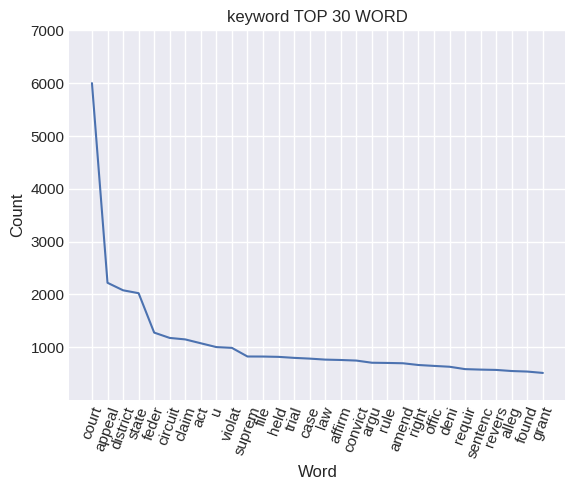

In [ ]:
make_top_word_graph(ww_list, 30)

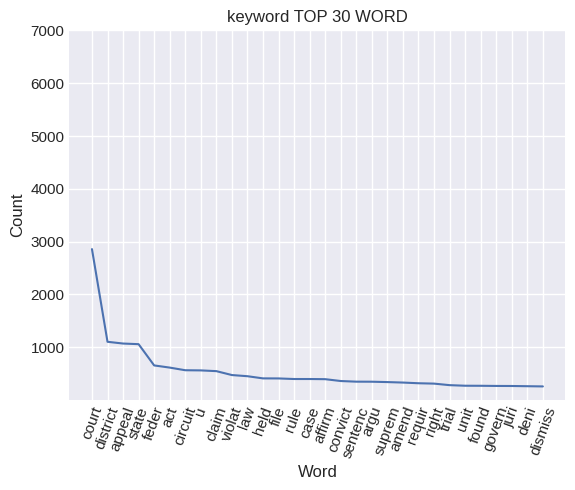

In [ ]:
make_top_word_graph(lw_list, 30)

### 의미없는 중복되는 문장

In [ ]:
test = train[train.facts.str.contains('The U.S. Court of Appeals for the')].facts
test

1       Ramon Nelson was riding his bike when he suffe...
6       Sections of the Immigration and Nationality Ac...
13      Groups of same-sex couples sued their relevant...
17      In 2004, Steven Spears was charged and convict...
23      In December 1980, the Rhode Island State Polic...
                              ...                        
2444    Jeffrey Heffernan was a police officer for the...
2451    In the spring of 1994, Hana Bank, a Korean ent...
2453    On October 10, 1980, an Oklahoma City police o...
2455    Gregory Holt (also known as Abdul Maalik Muham...
2464    On August 17, 1972, a postal inspector receive...
Name: facts, Length: 384, dtype: object

In [ ]:
## Circuit affirmed
test = re.sub(pattern = "The U.S. Court of Appeals for the", repl = "",	string = test)
test

'Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lineup, he was tried and convicted for Nelson’s death. Because Nelson was carrying cocaine and crack cocaine potentially for distribution, the judge at Owens’ bench trial ruled that Owens was probably also a drug dealer and was trying to “knock [Nelson] off.” Owens was found guilty of first-degree murder and sentenced to 25 years in prison.\r\nOwens filed a petition for a writ of habeas corpus on the grounds that his constitutional right to due process was violated during the trial. He argued that the eyewitness identification should have been inadmissible based on unreliability and that the judge impermissibly inferred a motive when a motive was not an element of the offense. The district court denied the writ of habeas corpus, and Owens appealed.  Seventh Circuit reversed the denial and held t

In [ ]:
def non_meaning(str):
    replaceAll = str
    sentence_str = 'The U.S. Court of Appeals for the'
    # 빈도수 많이 나오는 공통 어구(일치하는 문자) 제거
    ## https://heytech.tistory.com/38
    ## https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-5%EC%9D%BC%EC%B0%A8-70b1d773d30a
    test = re.sub(pattern = sentence_str, repl = "",	string = replaceAll)
    return test

In [ ]:
train_df = train[['first_party','second_party','facts','first_party_winner']]
train_df['fact_processing'] = train_df['facts'].apply(non_meaning)
train_df

,first_party,second_party,facts,first_party_winner,fact_processing
0,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,"On June 27, 1962, Phil St. Amant, a candidate ..."
1,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,Ramon Nelson was riding his bike when he suffe...
2,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,An Alabama state court convicted Billy Joe Mag...
3,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,Victor Linkletter was convicted in state court...
4,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,"On April 24, 1953 in Selma, Alabama, an intrud..."
...,...,...,...,...,...
2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",Congress amended the Clean Air Act through the...,1,Congress amended the Clean Air Act through the...
2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",1,"Alliance Bond Fund, Inc., an investment fund, ..."
2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",0,"In 1992, the District Court sentenced Manuel D..."
2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",0,"On March 8, 1996, Enrico St. Cyr, a lawful per..."


### 키워드 추출
문서 집합에서 핵심이 되는 문장 추출하거나 요약
- 대소문자 통일
- 불용어 제거
- 단어 토큰화...?
- 어간추출 또는 표제어 추출
https://bkshin.tistory.com/entry/NLP-4-%EC%96%B4%EA%B0%84-%EC%B6%94%EC%B6%9CStemming%EA%B3%BC-%ED%91%9C%EC%A0%9C%EC%96%B4-%EC%B6%94%EC%B6%9CLemmatization

참고 : https://wonhwa.tistory.com/23

In [ ]:
line = train['facts_lst'][0]

In [ ]:
# 텍스트에서 특수문자 제거, 영어 다듬을 때 대소문자 통일
compile = re.compile("\W+")
for i in range(len(line)):
    a = compile.sub(" ",line[i])
    line[i] = a.lower()

line

['on june 27 1962 phil st amant a candidate for public office made a television speech in baton rouge louisiana ',
 'during this speech st amant accused his political opponent of being a communist and of being involved in criminal activities with the head of the local teamsters union ',
 'finally st amant implicated herman thompson an east baton rouge deputy sheriff in a scheme to move money between the teamsters union and st amant s political opponent ',
 'thompson successfully sued st amant for defamation ',
 'louisiana s first circuit court of appeals reversed holding that thompson did not show st amant acted with malice thompson then appealed to the supreme court of louisiana ',
 'that court held that although public figures forfeit some of their first amendment protection from defamation st amant accused thompson of a crime with utter disregard of whether the remarks were true ',
 'finally that court held that the first amendment protects uninhibited robust debate rather than an o

In [ ]:
# 사용하지 않는 단어인 불용어 제거
from nltk.corpus import stopwords
stop_word_eng = set(stopwords.words('english'))
line = [i for i in line if i not in stop_word_eng]
line

['on june 27 1962 phil st amant a candidate for public office made a television speech in baton rouge louisiana ',
 'during this speech st amant accused his political opponent of being a communist and of being involved in criminal activities with the head of the local teamsters union ',
 'finally st amant implicated herman thompson an east baton rouge deputy sheriff in a scheme to move money between the teamsters union and st amant s political opponent ',
 'thompson successfully sued st amant for defamation ',
 'louisiana s first circuit court of appeals reversed holding that thompson did not show st amant acted with malice thompson then appealed to the supreme court of louisiana ',
 'that court held that although public figures forfeit some of their first amendment protection from defamation st amant accused thompson of a crime with utter disregard of whether the remarks were true ',
 'finally that court held that the first amendment protects uninhibited robust debate rather than an o

In [ ]:
# 표제어 추출 : 단어의 품사 정보를 알아야만 정확한 결과 get
lemma = WordNetLemmatizer()
lemma.lemmatize(line)

TypeError: ignored

In [ ]:
# 어간추출-> 표제어보다 성능 낮음
ps_stemmer = PorterStemmer()
token = RegexpTokenizer('[\w]+')

result2 = [token.tokenize(i) for i in line]
middle_result2= [r for i in result2 for r in i]
final_result2 = [ps_stemmer.stem(i) for i in middle_result2 if not i in stop_word_eng] # 불용어 제거
final_result2

['june',
 '27',
 '1962',
 'phil',
 'st',
 'amant',
 'candid',
 'public',
 'offic',
 'made',
 'televis',
 'speech',
 'baton',
 'roug',
 'louisiana',
 'speech',
 'st',
 'amant',
 'accus',
 'polit',
 'oppon',
 'communist',
 'involv',
 'crimin',
 'activ',
 'head',
 'local',
 'teamster',
 'union',
 'final',
 'st',
 'amant',
 'implic',
 'herman',
 'thompson',
 'east',
 'baton',
 'roug',
 'deputi',
 'sheriff',
 'scheme',
 'move',
 'money',
 'teamster',
 'union',
 'st',
 'amant',
 'polit',
 'oppon',
 'thompson',
 'success',
 'su',
 'st',
 'amant',
 'defam',
 'louisiana',
 'first',
 'circuit',
 'court',
 'appeal',
 'revers',
 'hold',
 'thompson',
 'show',
 'st',
 'amant',
 'act',
 'malic',
 'thompson',
 'appeal',
 'suprem',
 'court',
 'louisiana',
 'court',
 'held',
 'although',
 'public',
 'figur',
 'forfeit',
 'first',
 'amend',
 'protect',
 'defam',
 'st',
 'amant',
 'accus',
 'thompson',
 'crime',
 'utter',
 'disregard',
 'whether',
 'remark',
 'true',
 'final',
 'court',
 'held',
 'first',

In [ ]:
# 텍스트에서 제일 많이 나온 단어 10개 반환
english = pd.Series(final_result2).value_counts().head(10)
print("< English top 10 >")
print(english)

< English top 10 >
st           7
amant        7
thompson     5
court        4
louisiana    3
public       3
first        3
amend        2
teamster     2
union        2
dtype: int64
